# Load packages

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import functools
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from scipy import stats
import numpy as np
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set_style("whitegrid")

/Users/cecilia/opt/anaconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/cecilia/opt/anaconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data 

In [105]:
spx = pd.read_excel('30min2.xlsx', sheet_name=0,index_col=0)
gold = pd.read_excel('30min2.xlsx', sheet_name=1,index_col=0)
btc = pd.read_excel('30min2.xlsx', sheet_name=2,index_col=0)
vix = pd.read_excel('30min2.xlsx', sheet_name=3,index_col=0)
bond = pd.read_excel('30min2.xlsx', sheet_name=4,index_col=0)

In [106]:
spx.index = pd.to_datetime(spx.index)
gold.index = pd.to_datetime(gold.index)
btc.index = pd.to_datetime(btc.index)
vix.index = pd.to_datetime(vix.index)
bond.index = pd.to_datetime(bond.index)

In [107]:
vix.index=vix.index.floor('30min')

In [108]:
vix.index

DatetimeIndex(['2022-06-14 14:30:00', '2022-06-14 14:00:00',
               '2022-06-14 13:30:00', '2022-06-14 13:00:00',
               '2022-06-14 12:30:00', '2022-06-14 12:00:00',
               '2022-06-14 11:30:00', '2022-06-14 11:00:00',
               '2022-06-14 10:30:00', '2022-06-14 10:00:00',
               ...
               '2021-09-28 07:30:00', '2021-09-28 07:00:00',
               '2021-09-28 06:30:00', '2021-09-28 06:00:00',
               '2021-09-28 05:30:00', '2021-09-28 05:00:00',
               '2021-09-28 04:30:00', '2021-09-28 04:00:00',
               '2021-09-28 03:30:00', '2021-09-28 03:00:00'],
              dtype='datetime64[ns]', name='Date', length=4688, freq=None)

In [109]:
data_align= pd.concat([spx['Close'], gold['Close'],btc['Close'],vix['Close'],bond['Close']], axis=1, join="inner",keys=["spx","gold","btc","vix","bond"])

In [110]:
data_align

,spx,gold,btc,vix,bond
Date,,,,,
2022-06-14 14:30:00,3721.50,1807.36,22269.02,32.72,3.4830
2022-06-14 14:00:00,3735.56,1810.35,22418.58,32.33,3.4444
2022-06-14 13:30:00,3731.34,1811.53,22332.34,32.69,3.4540
2022-06-14 13:00:00,3748.58,1811.84,22620.06,32.79,3.4617
2022-06-14 12:30:00,3739.18,1812.37,22464.16,32.67,3.4444
...,...,...,...,...,...
2022-03-03 11:30:00,4369.66,1930.30,42417.03,30.52,1.8387
2022-03-03 11:00:00,4364.70,1928.07,42687.19,30.71,1.8370
2022-03-03 10:30:00,4355.25,1926.38,42554.17,31.87,1.8680


In [111]:
data_rets=data_align.pct_change()
rets_roll_daily=data_rets.rolling(13).mean().dropna()
rets_roll_week=data_rets.rolling(65).mean().dropna()
corr=pd.DataFrame()
corr['btc_spx'] = data_rets['btc'].rolling(65).corr(data_rets['spx']).dropna()
corr['btc_gold'] = data_rets['btc'].rolling(65).corr(data_rets['gold']).dropna()

In [9]:
rets_roll_week

,spx,gold,btc,vix,bond
Date,,,,,
2022-06-07 14:30:00,0.001668,0.000403,0.005066,-0.004322,-0.002431
2022-06-07 14:00:00,0.001622,0.000360,0.004966,-0.004043,-0.002309
2022-06-07 13:30:00,0.001591,0.000332,0.004895,-0.004246,-0.002342
2022-06-07 13:00:00,0.001528,0.000320,0.004697,-0.004173,-0.002319
2022-06-07 12:30:00,0.001535,0.000332,0.004786,-0.003997,-0.002204
...,...,...,...,...,...
2022-03-03 11:30:00,0.000534,-0.000490,0.001354,-0.000573,-0.001246
2022-03-03 11:00:00,0.000559,-0.000516,0.001449,-0.000634,-0.001234
2022-03-03 10:30:00,0.000488,-0.000527,0.001391,0.000003,-0.000947


In [10]:
daily_rets_daily_lag = rets_roll_daily.shift(-13).dropna()
daily_rets_weekly_lag = rets_roll_daily.shift(-65).dropna()
weekly_rets_daily_lag = rets_roll_week.shift(-13).dropna()
weekly_rets_weekly_lag = rets_roll_week.shift(-65).dropna()

In [11]:
daily_rets_half_lag = rets_roll_daily.shift(-7).dropna()
weekly_rets_half_lag = rets_roll_week.shift(-7).dropna()

In [12]:
daily_rets_daily_lag.columns = ["spx_daily_lag", "gold_daily_lag", "btc_daily_lag", "vix_daily_lag", "bond_daily_lag"]
daily_rets_weekly_lag.columns = ["spx_weekly_lag", "gold_weekly_lag", "btc_weekly_lag", "vix_weekly_lag", "bond_weekly_lag"]

In [13]:
daily_rets_half_lag.columns = ["spx_half_lag", "gold_half_lag", "btc_half_lag", "vix_half_lag", "bond_half_lag"]
weekly_rets_half_lag.columns = ["spx_half_lag", "gold_half_lag", "btc_half_lag", "vix_half_lag", "bond_half_lag"]

In [14]:
weekly_rets_daily_lag.columns = ["spx_daily_lag", "gold_daily_lag", "btc_daily_lag", "vix_daily_lag", "bond_daily_lag"]
weekly_rets_weekly_lag.columns = ["spx_weekly_lag", "gold_weekly_lag", "btc_weekly_lag", "vix_weekly_lag", "bond_weekly_lag"]

In [15]:
daily_rets_daily_lag = pd.concat([rets_roll_daily, daily_rets_daily_lag], axis = 1).dropna()
daily_rets_weekly_lag = pd.concat([rets_roll_daily, daily_rets_weekly_lag], axis = 1).dropna()

In [16]:
weekly_rets_daily_lag = pd.concat([rets_roll_week, weekly_rets_daily_lag], axis = 1).dropna()
weekly_rets_weekly_lag = pd.concat([rets_roll_week, weekly_rets_weekly_lag], axis = 1).dropna()

In [17]:
daily_rets_half_lag = pd.concat([rets_roll_daily, daily_rets_half_lag], axis = 1).dropna()
weekly_rets_half_lag = pd.concat([rets_roll_week, weekly_rets_half_lag], axis = 1).dropna()

In [18]:
daily_rets_half_lag

,spx,gold,btc,vix,bond,spx_half_lag,gold_half_lag,btc_half_lag,vix_half_lag,bond_half_lag
Date,,,,,,,,,,
2022-03-03 13:00:00,0.001254,-0.001162,0.003073,-0.006373,0.005336,0.001415,-0.000938,0.004288,-0.008053,0.007091
2022-03-03 13:30:00,0.001346,-0.001228,0.003081,-0.009251,0.005583,0.001426,-0.001136,0.004153,-0.005314,0.006683
2022-03-03 14:00:00,0.001335,-0.001309,0.003914,-0.007055,0.005141,0.001152,-0.001248,0.003471,-0.005378,0.007300
2022-03-03 14:30:00,0.001244,-0.001246,0.004617,-0.004278,0.005466,0.001228,-0.001333,0.003764,-0.007992,0.006156
2022-03-03 15:00:00,0.001031,-0.001181,0.005345,-0.001627,0.005509,0.001281,-0.001295,0.003102,-0.006139,0.005920
...,...,...,...,...,...,...,...,...,...,...
2022-06-13 12:30:00,0.000900,0.000696,0.004223,0.001403,-0.002315,0.003051,0.002073,0.018956,-0.014411,-0.005045
2022-06-13 13:00:00,0.000567,0.000791,0.002195,-0.000007,-0.002744,0.000490,0.000608,0.004229,-0.000178,-0.001688
2022-06-13 13:30:00,0.001309,0.000734,0.004045,0.000788,-0.002439,0.000661,0.000582,0.004528,0.001471,-0.001850


In [19]:
corr

,btc_spx,btc_gold
Date,,
2022-06-07 14:30:00,0.688389,0.811367
2022-06-07 14:00:00,0.689090,0.811652
2022-06-07 13:30:00,0.689445,0.813250
2022-06-07 13:00:00,0.689365,0.813992
2022-06-07 12:30:00,0.688014,0.813721
...,...,...
2022-03-03 11:30:00,0.642537,-0.541881
2022-03-03 11:00:00,0.641227,-0.541887
2022-03-03 10:30:00,0.642925,-0.541225


In [20]:
corr.to_csv("btc_corr.csv")

In [21]:
data_used = pd.concat([corr, vix['Close'], bond['Close']], axis=1).dropna()

In [22]:
data_used.columns = ["btc_spx", "btc_gold", "vix", "bond"]

In [23]:
data_used

,btc_spx,btc_gold,vix,bond
Date,,,,
2022-03-03 09:30:00,0.650923,-0.535574,30.41,1.8871
2022-03-03 10:00:00,0.649135,-0.537749,31.36,1.8698
2022-03-03 10:30:00,0.642925,-0.541225,31.87,1.8680
2022-03-03 11:00:00,0.641227,-0.541887,30.71,1.8370
2022-03-03 11:30:00,0.642537,-0.541881,30.52,1.8387
...,...,...,...,...
2022-06-07 12:30:00,0.688014,0.813721,24.59,2.9791
2022-06-07 13:00:00,0.689365,0.813992,24.40,2.9717
2022-06-07 13:30:00,0.689445,0.813250,24.21,2.9607


In [24]:
daily_lag = data_used.shift(-13).dropna()
weekly_lag = data_used.shift(-65).dropna()

In [25]:
daily_lag.columns = ["btc_spx_daily_lag", "btc_gold_daily_lag", "vix_daily_lag", "bond_daily_lag"]

In [26]:
weekly_lag.columns = ["btc_spx_weekly_lag", "btc_gold_weekly_lag", "vix_weekly_lag", "bond_weekly_lag"]

<AxesSubplot:xlabel='Date'>

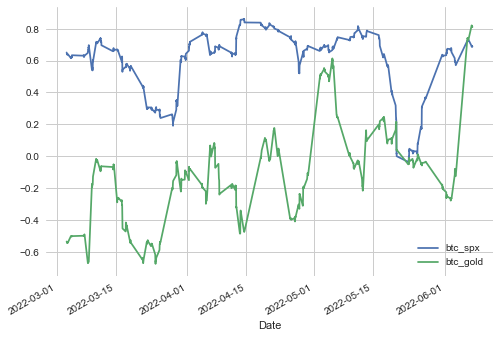

In [27]:
corr.plot()

In [28]:
daily_lag

,btc_spx_daily_lag,btc_gold_daily_lag,vix_daily_lag,bond_daily_lag
Date,,,,
2022-03-03 09:30:00,0.617194,-0.502265,34.06,1.7256
2022-03-03 10:00:00,0.617483,-0.501078,33.88,1.7188
2022-03-03 10:30:00,0.614838,-0.500140,34.46,1.7035
2022-03-03 11:00:00,0.617609,-0.501221,34.33,1.7001
2022-03-03 11:30:00,0.616444,-0.501506,33.32,1.7069
...,...,...,...,...
2022-06-06 12:30:00,0.688014,0.813721,24.59,2.9791
2022-06-06 13:00:00,0.689365,0.813992,24.40,2.9717
2022-06-06 13:30:00,0.689445,0.813250,24.21,2.9607


In [29]:
corr_daily_lag = pd.concat([data_used, daily_lag], axis = 1).dropna()

In [30]:
corr_weekly_lag = pd.concat([data_used, weekly_lag], axis = 1).dropna()

In [31]:
corr_lags = pd.concat([data_used, daily_lag, weekly_lag], axis = 1).dropna()

In [32]:
corr_lags = corr_lags.drop(['btc_spx_daily_lag','btc_gold_daily_lag','btc_spx_weekly_lag','btc_gold_weekly_lag'],axis = 1)

corr_daily_lag = corr_daily_lag.drop(['btc_spx_daily_lag','btc_gold_daily_lag'],axis=1)
corr_weekly_lag = corr_weekly_lag.drop(['btc_spx_weekly_lag','btc_gold_weekly_lag'],axis=1)

In [33]:
corr_lags

,btc_spx,btc_gold,vix,bond,vix_daily_lag,bond_daily_lag,vix_weekly_lag,bond_weekly_lag
Date,,,,,,,,
2022-03-03 09:30:00,0.650923,-0.535574,30.41,1.8871,34.06,1.7256,31.98,1.9899
2022-03-03 10:00:00,0.649135,-0.537749,31.36,1.8698,33.88,1.7188,32.10,2.0004
2022-03-03 10:30:00,0.642925,-0.541225,31.87,1.8680,34.46,1.7035,32.56,1.9986
2022-03-03 11:00:00,0.641227,-0.541887,30.71,1.8370,34.33,1.7001,32.68,2.0021
2022-03-03 11:30:00,0.642537,-0.541881,30.52,1.8387,33.32,1.7069,32.35,2.0056
...,...,...,...,...,...,...,...,...
2022-05-31 12:30:00,0.629426,-0.201829,26.34,2.8423,27.13,2.9442,24.59,2.9791
2022-05-31 13:00:00,0.628247,-0.205791,26.28,2.8405,26.47,2.9423,24.40,2.9717
2022-05-31 13:30:00,0.628526,-0.201325,26.08,2.8441,26.46,2.9387,24.21,2.9607


<AxesSubplot:xlabel='Date'>

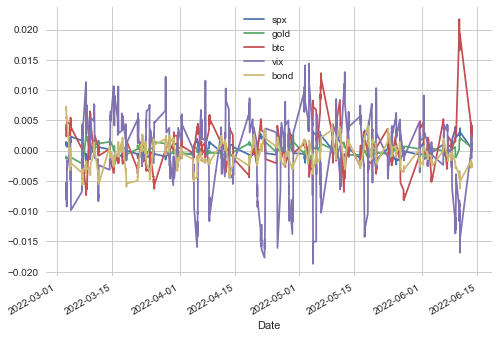

In [34]:
rets_roll_daily.plot()

<AxesSubplot:xlabel='Date'>

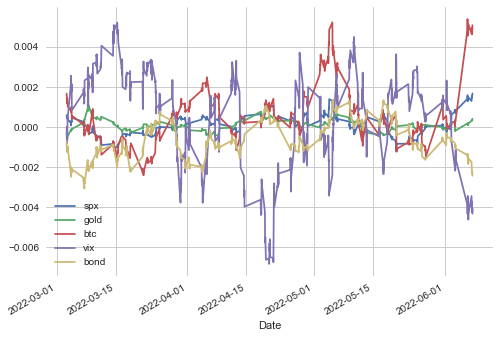

In [35]:
rets_roll_week.plot()

<AxesSubplot:xlabel='Date'>

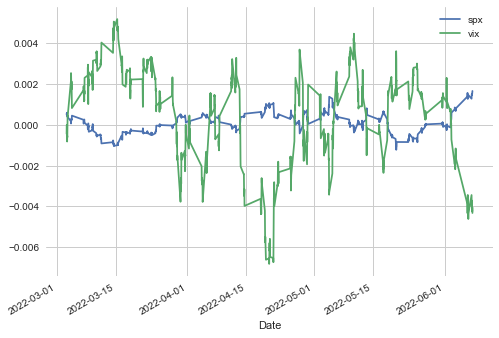

In [36]:
rets_roll_week[['spx','vix']].plot()

<AxesSubplot:xlabel='Date'>

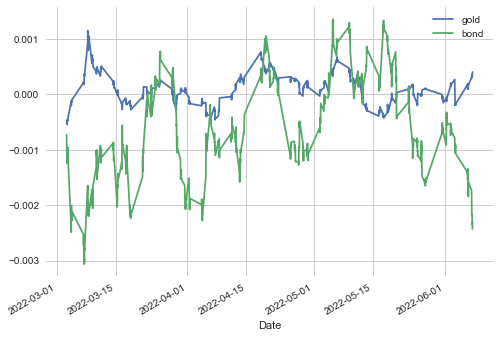

In [37]:
rets_roll_week[['gold','bond']].plot()

<AxesSubplot:xlabel='Date'>

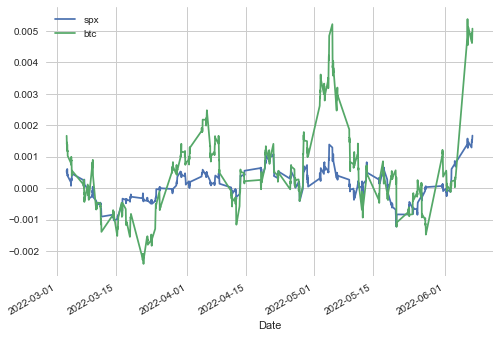

In [38]:
rets_roll_week[['spx','btc']].plot()

In [39]:
rets_roll_week.corr().style.background_gradient(cmap='coolwarm') 

,spx,gold,btc,vix,bond
spx,1.000000,0.111542,0.751133,-0.836851,0.109686
gold,0.111542,1.000000,0.100876,-0.111035,0.044145
btc,0.751133,0.100876,1.000000,-0.526408,0.085542
vix,-0.836851,-0.111035,-0.526408,1.000000,-0.132229
bond,0.109686,0.044145,0.085542,-0.132229,1.000000


# Simple Linear Regression model 

### NO Lag

In [40]:
X=data_used[['vix','bond']]
X = sm.add_constant(X) # adding a constant
Y=data_used['btc_spx']
model_btc_spy = sm.OLS(Y, X).fit()
predictions = model_btc_spy.predict(X) 

model_btc_spy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                btc_spx   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.002
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           0.000360
Time:                        12:54:28   Log-Likelihood:                 148.24
No. Observations:                 861   AIC:                            -290.5
Df Residuals:                     858   BIC:                            -276.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3635      0.066      5.534      0.000       0.235       0.492
vix            0.0014      0.002      0.923      0.356      -0.002       0.004
bond           0.0746      0.019      3.922      0.000       0.037       0.112
==============================================================================
Omnibus:                      217.681   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              416.375
Skew:                          -1.499   Prob(JB):                     3.85e-91
Kurtosis:                       4.617   Cond. No.                         266.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
Y2=data_used['btc_gold']
model_btc_gold = sm.OLS(Y2, X).fit()
predictions = model_btc_gold.predict(X) 

model_btc_gold.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               btc_gold   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     278.2
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           7.48e-94
Time:                        12:54:28   Log-Likelihood:                -25.215
No. Observations:                 861   AIC:                             56.43
Df Residuals:                     858   BIC:                             70.70
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7696      0.080    -22.024      0.000      -1.927      -1.612
vix            0.0092      0.002      4.980      0.000       0.006       0.013
bond           0.5399      0.023     23.214      0.000       0.494       0.586
==============================================================================
Omnibus:                       35.244   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.697
Skew:                           0.517   Prob(JB):                     3.95e-09
Kurtosis:                       3.092   Cond. No.                         266.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Including Daily Lags

In [42]:
# spx-btc
X=corr_daily_lag[['vix','bond','vix_daily_lag','bond_daily_lag']]
X = sm.add_constant(X)
Y=corr_daily_lag['btc_spx']
model_btc_spy_daily_lag = sm.OLS(Y, X).fit()
predictions = model_btc_spy_daily_lag.predict(X) 

model_btc_spy_daily_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                btc_spx   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     14.14
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           3.57e-11
Time:                        12:54:28   Log-Likelihood:                 160.83
No. Observations:                 848   AIC:                            -311.7
Df Residuals:                     843   BIC:                            -287.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2663      0.067      3.949      0.000       0.134       0.399
vix               -0.0134      0.003     -4.026      0.000      -0.020      -0.007
bond              -0.3503      0.098     -3.560      0.000      -0.543      -0.157
vix_daily_lag      0.0175      0.003      5.200      0.000       0.011       0.024
bond_daily_lag     0.4320      0.101      4.278      0.000       0.234       0.630
==============================================================================
Omnibus:                      189.144   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              334.397
Skew:                          -1.375   Prob(JB):                     2.44e-73
Kurtosis:                       4.378   Cond. No.                         794.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# gold-btc
X=corr_daily_lag[['vix','bond','vix_daily_lag','bond_daily_lag']]
X = sm.add_constant(X)
Y=corr_daily_lag['btc_gold']
model_btc_gold_daily_lag = sm.OLS(Y, X).fit()
predictions = model_btc_gold_daily_lag.predict(X) 

model_btc_gold_daily_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               btc_gold   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     142.9
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           2.89e-93
Time:                        12:54:28   Log-Likelihood:                 32.537
No. Observations:                 848   AIC:                            -55.07
Df Residuals:                     843   BIC:                            -31.36
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.6938      0.078    -21.588      0.000      -1.848      -1.540
vix                0.0079      0.004      2.023      0.043       0.000       0.015
bond               0.7160      0.114      6.255      0.000       0.491       0.941
vix_daily_lag      0.0023      0.004      0.583      0.560      -0.005       0.010
bond_daily_lag    -0.2177      0.117     -1.853      0.064      -0.448       0.013
==============================================================================
Omnibus:                       24.390   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.345
Skew:                           0.364   Prob(JB):                     8.52e-06
Kurtosis:                       2.637   Cond. No.                         794.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Including Weekly Lags

In [44]:
# spx-btc
X=corr_weekly_lag[['vix','bond','vix_weekly_lag','bond_weekly_lag']]
X = sm.add_constant(X)
Y=corr_weekly_lag['btc_spx']
model_btc_spy_weekly_lag = sm.OLS(Y, X).fit()
predictions = model_btc_spy_weekly_lag.predict(X) 

model_btc_spy_weekly_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                btc_spx   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     59.37
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           7.40e-44
Time:                        12:54:28   Log-Likelihood:                 208.16
No. Observations:                 796   AIC:                            -406.3
Df Residuals:                     791   BIC:                            -382.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2852      0.076      3.766      0.000       0.137       0.434
vix                -0.0147      0.002     -8.256      0.000      -0.018      -0.011
bond               -0.1274      0.045     -2.810      0.005      -0.216      -0.038
vix_weekly_lag      0.0307      0.002     14.907      0.000       0.027       0.035
bond_weekly_lag     0.0831      0.055      1.517      0.130      -0.024       0.191
==============================================================================
Omnibus:                      120.231   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.411
Skew:                          -1.030   Prob(JB):                     6.67e-40
Kurtosis:                       4.092   Cond. No.                         516.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# gold-btc
Y=corr_weekly_lag['btc_gold']
model_btc_gold_weekly_lag = sm.OLS(Y, X).fit()
predictions = model_btc_gold_weekly_lag.predict(X) 

model_btc_gold_weekly_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               btc_gold   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     177.0
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          2.92e-108
Time:                        12:54:28   Log-Likelihood:                 101.23
No. Observations:                 796   AIC:                            -192.5
Df Residuals:                     791   BIC:                            -169.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5129      0.087    -17.470      0.000      -1.683      -1.343
vix                 0.0016      0.002      0.791      0.429      -0.002       0.006
bond                0.6491      0.052     12.514      0.000       0.547       0.751
vix_weekly_lag      0.0148      0.002      6.273      0.000       0.010       0.019
bond_weekly_lag    -0.2728      0.063     -4.355      0.000      -0.396      -0.150
==============================================================================
Omnibus:                       52.635   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.117
Skew:                          -0.014   Prob(JB):                     7.06e-05
Kurtosis:                       2.241   Cond. No.                         516.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Including BOTH Daily and Weekly Lags

In [46]:
# spx-btc
X=corr_lags[['vix','bond','vix_daily_lag','bond_daily_lag','vix_weekly_lag','bond_weekly_lag']]
X = sm.add_constant(X)
Y=corr_lags['btc_spx']
model_btc_spy_lag = sm.OLS(Y, X).fit()
predictions = model_btc_spy_lag.predict(X) 

model_btc_spy_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                btc_spx   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     42.34
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           7.18e-45
Time:                        12:54:28   Log-Likelihood:                 214.75
No. Observations:                 796   AIC:                            -415.5
Df Residuals:                     789   BIC:                            -382.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2887      0.075      3.831      0.000       0.141       0.437
vix                -0.0144      0.003     -4.631      0.000      -0.021      -0.008
bond               -0.4198      0.093     -4.532      0.000      -0.602      -0.238
vix_daily_lag       0.0003      0.003      0.089      0.929      -0.006       0.007
bond_daily_lag      0.3745      0.104      3.612      0.000       0.171       0.578
vix_weekly_lag      0.0303      0.002     13.627      0.000       0.026       0.035
bond_weekly_lag    -0.0022      0.059     -0.037      0.970      -0.119       0.114
==============================================================================
Omnibus:                      103.009   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.527
Skew:                          -0.944   Prob(JB):                     4.13e-32
Kurtosis:                       3.889   Cond. No.                         972.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# gold-btc
Y=corr_lags['btc_gold']
model_btc_gold_lag = sm.OLS(Y, X).fit()
predictions = model_btc_gold_lag.predict(X) 

model_btc_gold_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               btc_gold   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     119.1
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          5.46e-107
Time:                        12:54:28   Log-Likelihood:                 103.51
No. Observations:                 796   AIC:                            -193.0
Df Residuals:                     789   BIC:                            -160.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5009      0.087    -17.321      0.000      -1.671      -1.331
vix                 0.0074      0.004      2.080      0.038       0.000       0.014
bond                0.5883      0.107      5.522      0.000       0.379       0.797
vix_daily_lag      -0.0076      0.004     -1.934      0.054      -0.015       0.000
bond_daily_lag      0.0782      0.119      0.656      0.512      -0.156       0.312
vix_weekly_lag      0.0166      0.003      6.501      0.000       0.012       0.022
bond_weekly_lag    -0.2954      0.068     -4.335      0.000      -0.429      -0.162
==============================================================================
Omnibus:                       51.509   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.365
Skew:                          -0.069   Prob(JB):                     6.24e-05
Kurtosis:                       2.248   Cond. No.                         972.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In general, from the OLS Regression Results, we can tell that the correlations between BTC and Gold can be better explained by the factors VIX and Treasuries. While we tried to introduce lags in the model, we can tell from both the Adjusted R-Squared and p-values that the weekly lags help in the explanatory power of the model, and overall have higher significance to interperate the correlations.

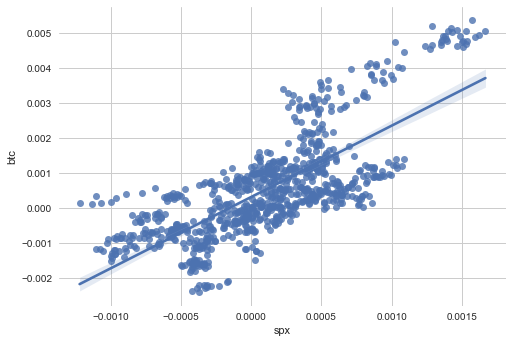

In [48]:
sns.regplot(x="spx", y="btc", data=rets_roll_week);

# PCA analysis

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### NOT Including Lags with Daily Returns

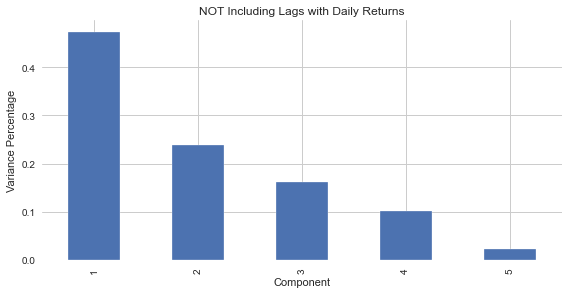

In [50]:
X=rets_roll_daily
sc = StandardScaler()
sc.fit_transform(X)
X_scaled = sc.transform(X)

sp_pca_daily = PCA()
sp_pca_daily.fit(X_scaled)
explained_variance = pd.DataFrame(sp_pca_daily.explained_variance_)
explained_variance['factor_pct'] = explained_variance[0]/explained_variance[0].sum()
explained_variance.index = list(range(1,len(explained_variance)+1))
#showing the first value
ax = explained_variance['factor_pct'].head(10).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
ax.set_ylabel('Variance Percentage')
plt.tight_layout()
plt.title("NOT Including Lags with Daily Returns")
plt.show()

<AxesSubplot:>

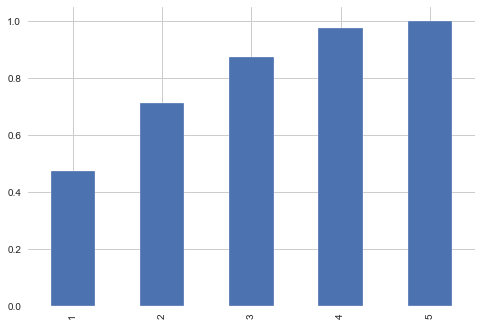

In [51]:
explained_variance['factor_pct'].cumsum().plot.bar(legend=False)

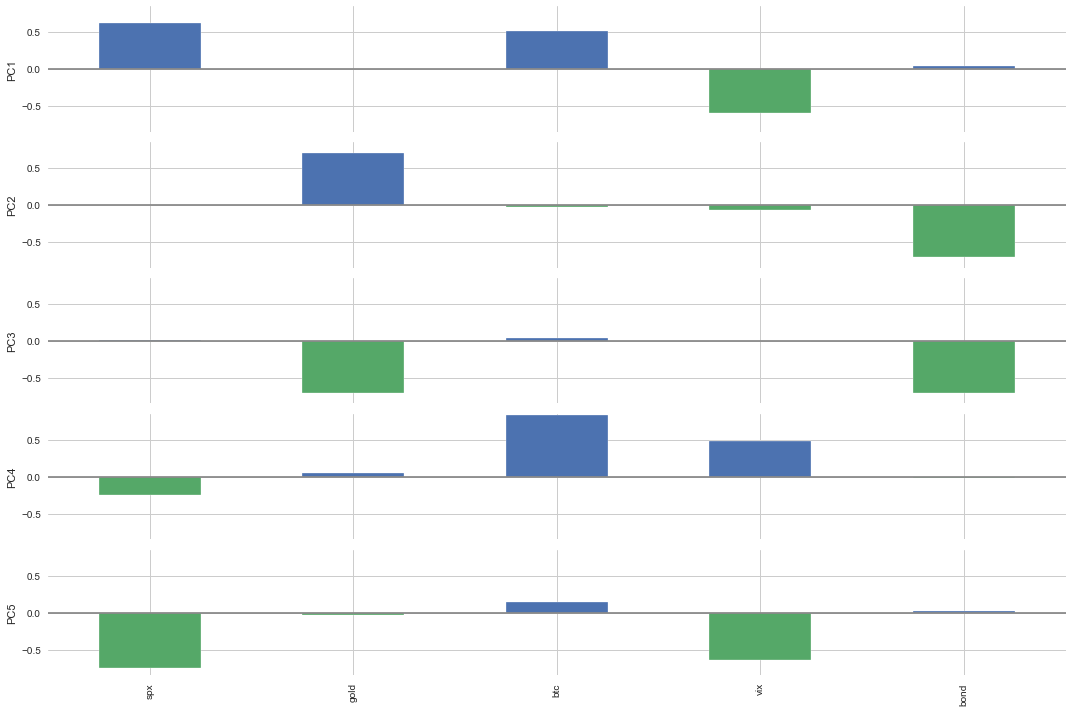

In [52]:
loadings = pd.DataFrame(sp_pca_daily.components_, 
                        columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
plt.tight_layout()
plt.show()

#### For PC1, we would call it a "RISK ASSETS" factor, with SPX and BTC being the "RISK ON" assets (positively correlated).
#### PC2: "HEDGE ASSETS" factor, with GOLD and Treasuries as "RISK OFF" assets.
#### PC3: "ROTATION BETWEEN HEDGE ASSETS" factor, with the rotation between GOLD and Treasuries.


### Including Half-day lags for daily returns

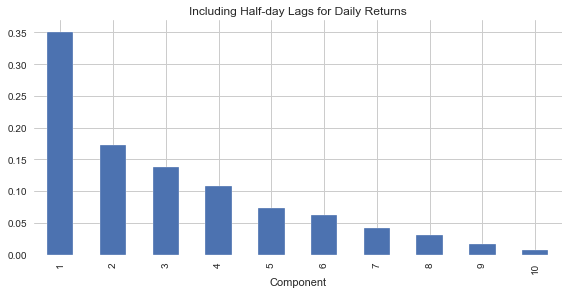

In [53]:
X=daily_rets_half_lag
sc = StandardScaler()
sc.fit_transform(X)
X_scaled = sc.transform(X)

sp_pca_half_lag = PCA()
sp_pca_half_lag.fit(X_scaled)
explained_variance = pd.DataFrame(sp_pca_half_lag.explained_variance_)
explained_variance['factor_pct'] = explained_variance[0]/explained_variance[0].sum()
explained_variance.index = list(range(1,len(explained_variance)+1))
#showing the first value
ax = explained_variance['factor_pct'].head(10).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.title("Including Half-day Lags for Daily Returns")
plt.show()

<AxesSubplot:>

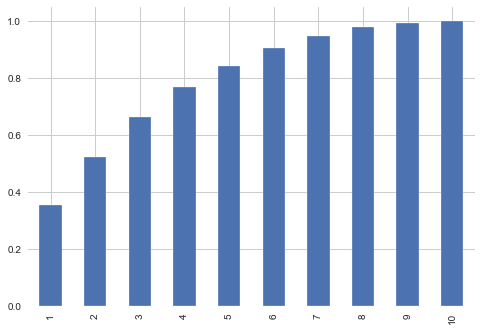

In [54]:
explained_variance['factor_pct'].cumsum().plot.bar(legend=False)

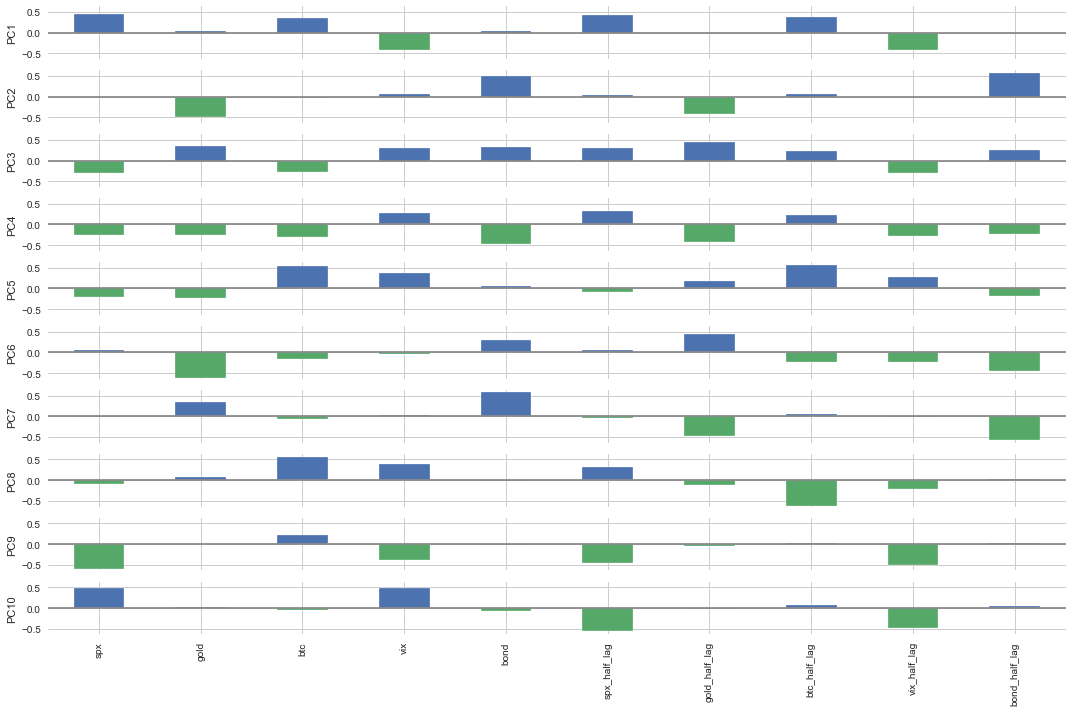

In [55]:
loadings = pd.DataFrame(sp_pca_half_lag.components_, 
                        columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(10, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
plt.tight_layout()
plt.show()

#### PC1: Similar to PC1 w/o lags, "RISK ASSETS" factor, with SPX, BTC and the half-day lag being the "RISK ON" assets (positively correlated), while they are also anticorrelated to VIX and its lags.
#### PC2: "HEDGE ASSETS" factor, with GOLD, Treasuries and their lags as "RISK OFF" assets.
#### PC3: "RISK ASSETS" factor, all assests "RISK ON" except for SPX, BTC and the lag of VIX.

### Including Daily Lags for Daily Returns

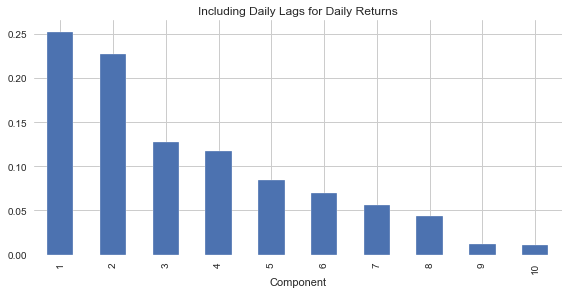

In [56]:
X=daily_rets_daily_lag
sc = StandardScaler()
sc.fit_transform(X)
X_scaled = sc.transform(X)

sp_pca_daily_lag = PCA()
sp_pca_daily_lag.fit(X_scaled)
explained_variance = pd.DataFrame(sp_pca_daily_lag.explained_variance_)
explained_variance['factor_pct'] = explained_variance[0]/explained_variance[0].sum()
explained_variance.index = list(range(1,len(explained_variance)+1))
#showing the first value
ax = explained_variance['factor_pct'].head(10).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.title("Including Daily Lags for Daily Returns")
plt.show()

<AxesSubplot:>

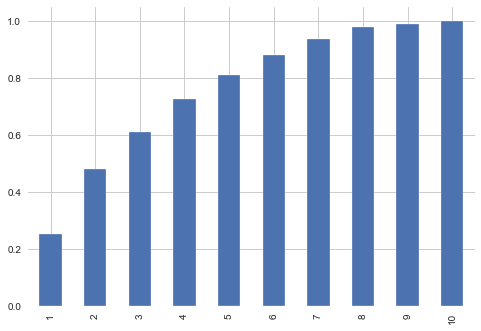

In [57]:
explained_variance['factor_pct'].cumsum().plot.bar(legend=False)

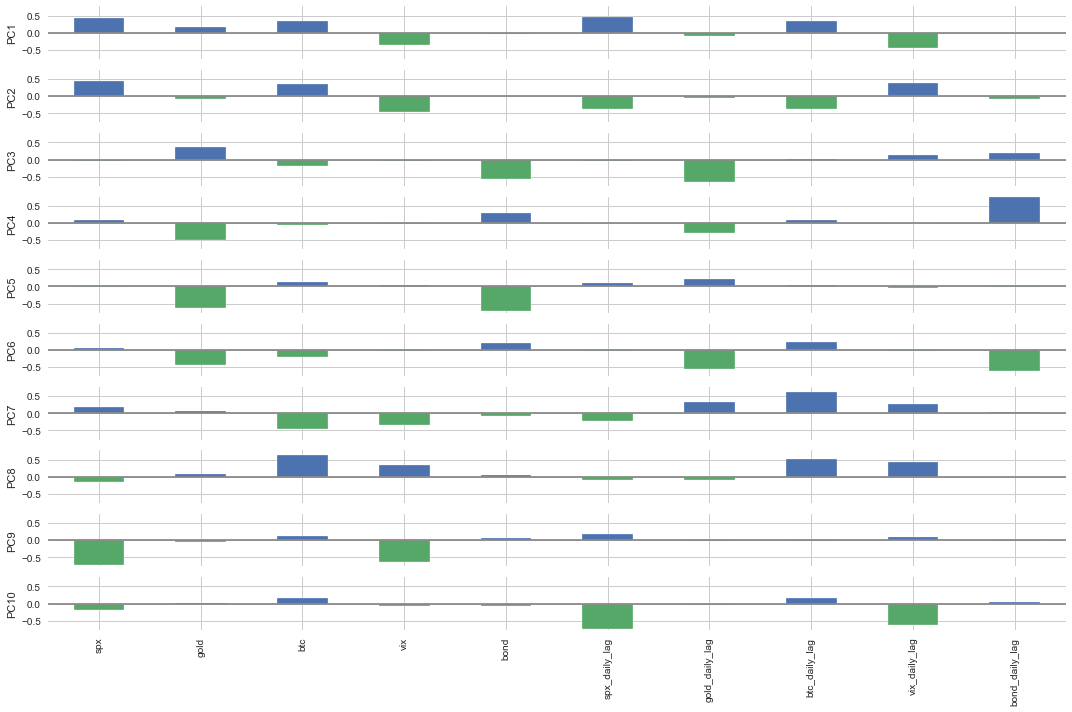

In [58]:
loadings = pd.DataFrame(sp_pca_daily_lag.components_, 
                        columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(10, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
plt.tight_layout()
plt.show()

#### PC1: Similar to the previous two PC1s, "RISK ASSETS" factor, with SPX, BTC and their daily lags being the "RISK ON" assets (positively correlated), while they are also anticorrelated to VIX and its lags.
#### PC2: "RISK ASSETS REVERSION" factor, different signs between SPX, BTC and their lags.
#### PC3: "ROTATION IN HEDGE ASSETS" factor, ROTATE between Treasuries and lag of GOLD.

### NOT Including Lags with Weekly Returns 

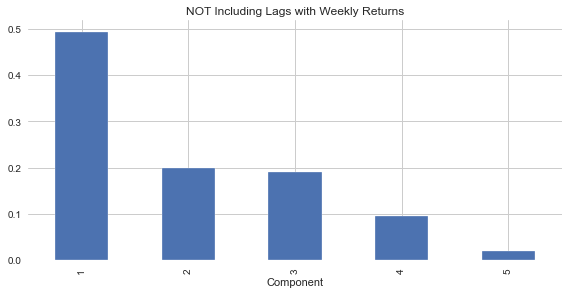

In [59]:
X=rets_roll_week
sc = StandardScaler()
sc.fit_transform(X)
X_scaled = sc.transform(X)

sp_pca_weekly = PCA()
sp_pca_weekly.fit(X_scaled)
explained_variance = pd.DataFrame(sp_pca_weekly.explained_variance_)
explained_variance['factor_pct'] = explained_variance[0]/explained_variance[0].sum()
explained_variance.index = list(range(1,len(explained_variance)+1))
#showing the first value
ax = explained_variance['factor_pct'].head(10).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.title("NOT Including Lags with Weekly Returns")
plt.show()

<AxesSubplot:>

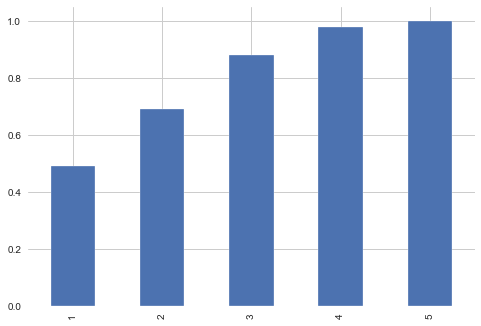

In [60]:
explained_variance['factor_pct'].cumsum().plot.bar(legend=False)

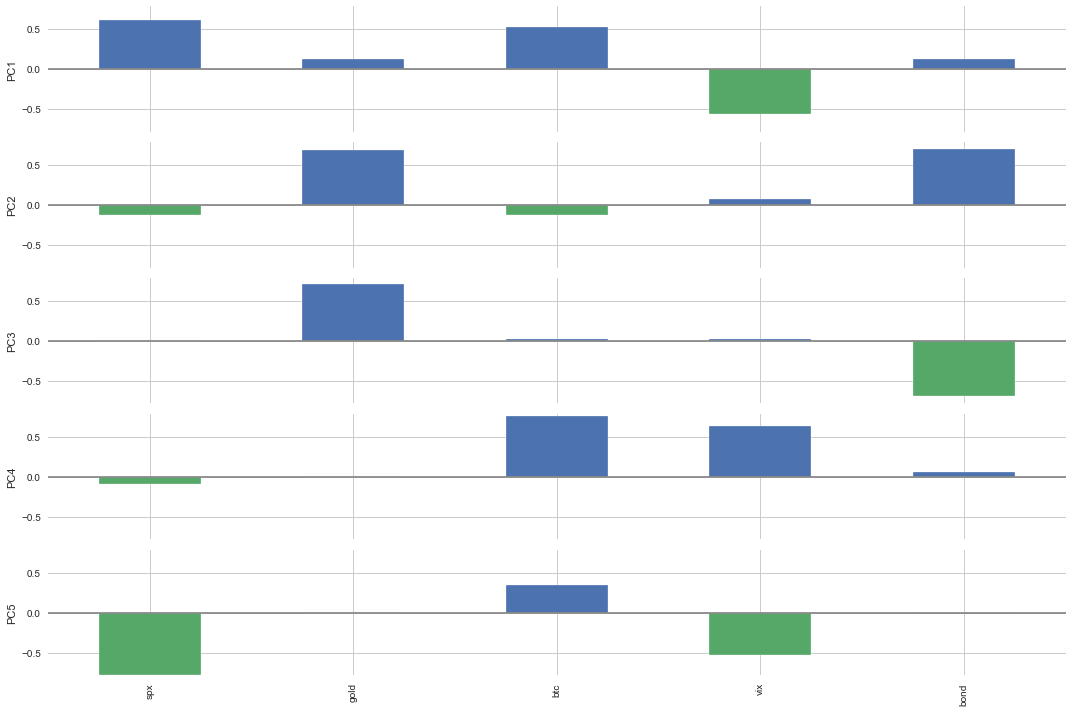

In [61]:
loadings = pd.DataFrame(sp_pca_weekly.components_, 
                        columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
plt.tight_layout()
plt.show()

#### PC1: "RISK ASSETS" factor, SPX and BTC "RISK ON". (anticorrelated with VIX)
#### PC2: "RISK ASSETS" factor, GOLD and Treasuries "RISK ON".
#### PC3: "HEDGE ASSET" factor, GOLD and Treasuries "RISK OFF".

### Including Half-day Lags for Weekly Returns

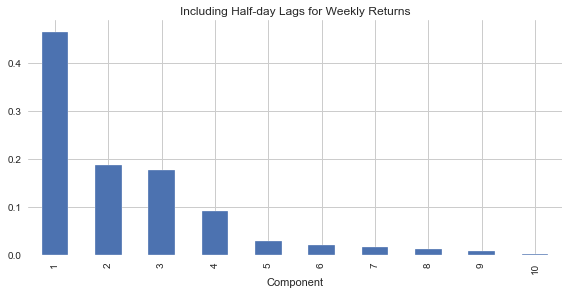

In [62]:
X=weekly_rets_half_lag
sc = StandardScaler()
sc.fit_transform(X)
X_scaled = sc.transform(X)

sp_pca_half_lag = PCA()
sp_pca_half_lag.fit(X_scaled)
explained_variance = pd.DataFrame(sp_pca_half_lag.explained_variance_)
explained_variance['factor_pct'] = explained_variance[0]/explained_variance[0].sum()
explained_variance.index = list(range(1,len(explained_variance)+1))
#showing the first value
ax = explained_variance['factor_pct'].head(10).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.title("Including Half-day Lags for Weekly Returns")
plt.show()

<AxesSubplot:>

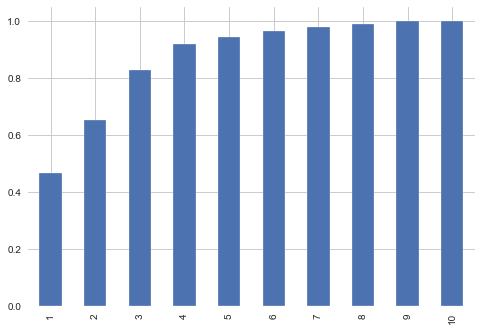

In [63]:
explained_variance['factor_pct'].cumsum().plot.bar(legend=False)

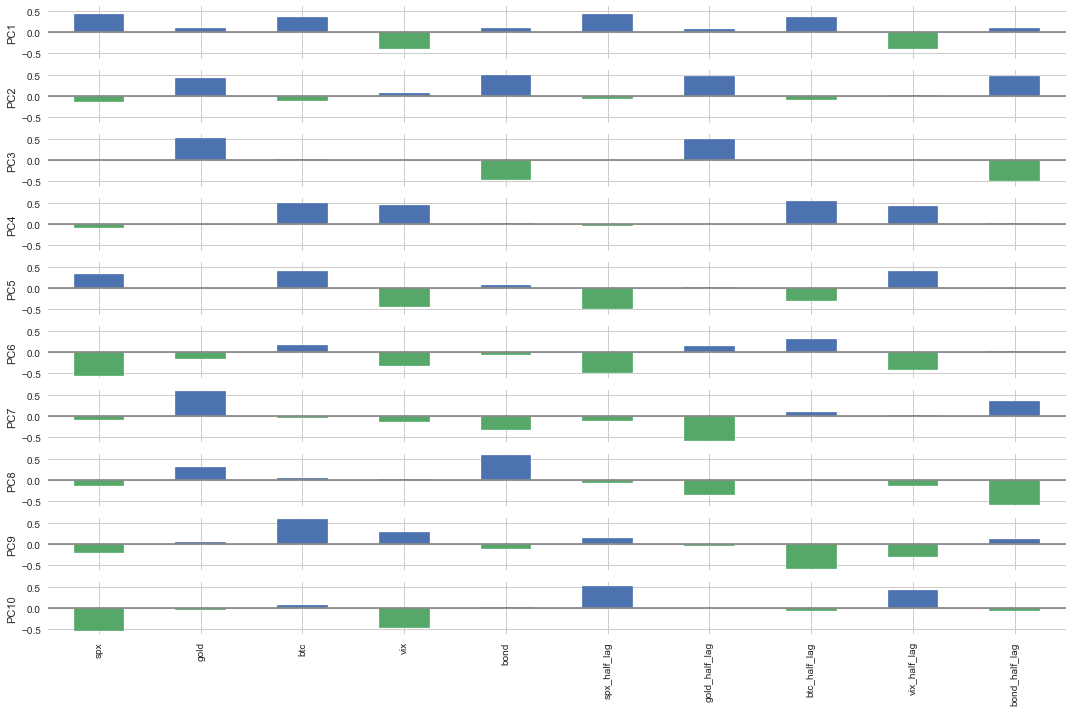

In [64]:
loadings = pd.DataFrame(sp_pca_half_lag.components_, 
                        columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(10, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
plt.tight_layout()
plt.show()

#### PC1: Similar to PC1 w/o lags, "RISK ASSETS" factor, SPX, BTC and their half-day lags "RISK ON". (anticorrelated with VIX and its lag)
#### PC2: Similar to PC2 w/o lags, "RISK ASSETS" factor, GOLD, Treasuries and their half-day lags "RISK ON".
#### PC3: Similar to PC3 w/o lags, "HEDGE ASSET" factor, (GOLD, its lag) and (Treasuries, its lag) "RISK OFF".
#### PC4: Similar to PC4 w/o lags, "RISK ASSETS" factor, BTC, VIX and their half-day lags "RISK ON".

#### Overall, the no-lag and half-day lag PCA components for weekly returns are very much alike.

### Including Daily Lags for Weekly Returns

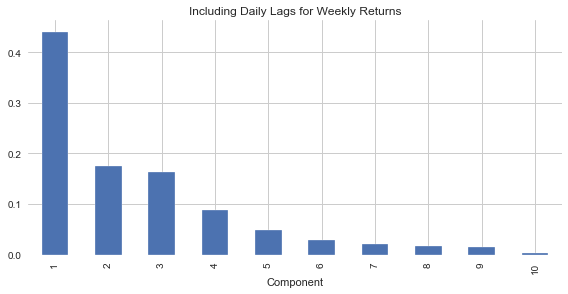

In [65]:
X=weekly_rets_daily_lag
sc = StandardScaler()
sc.fit_transform(X)
X_scaled = sc.transform(X)

sp_pca_daily_lag = PCA()
sp_pca_daily_lag.fit(X_scaled)
explained_variance = pd.DataFrame(sp_pca_daily_lag.explained_variance_)
explained_variance['factor_pct'] = explained_variance[0]/explained_variance[0].sum()
explained_variance.index = list(range(1,len(explained_variance)+1))
#showing the first value
ax = explained_variance['factor_pct'].head(10).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.title("Including Daily Lags for Weekly Returns")
plt.show()

<AxesSubplot:>

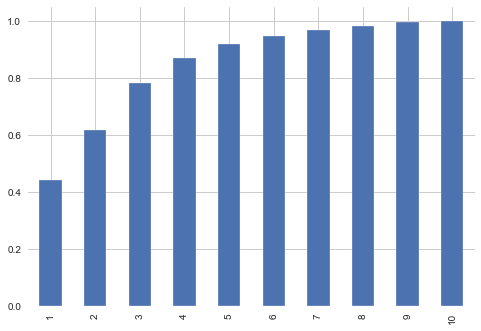

In [66]:
explained_variance['factor_pct'].cumsum().plot.bar(legend=False)

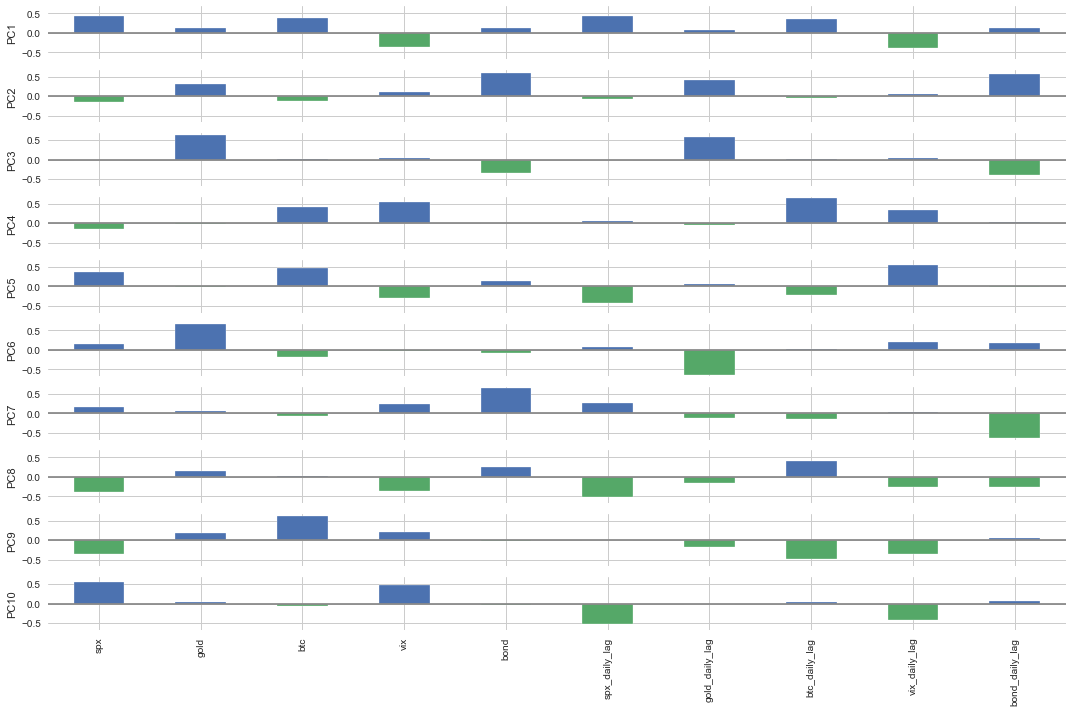

In [67]:
loadings = pd.DataFrame(sp_pca_daily_lag.components_, 
                        columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))
f, axes = plt.subplots(10, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
plt.tight_layout()
plt.show()

#### PC1: Similar previous two PC1's, "RISK ASSETS" factor, SPX, BTC and their daily lags "RISK ON". (anticorrelated with VIX and its lag)
#### PC2: Similar previous two PC2's, "RISK ASSETS" factor, GOLD, Treasuries and their daily lags "RISK ON".
#### PC3: Similar previous two PC3's, "HEDGE ASSET" factor, (GOLD, its lag) and (Treasuries, its lag) "RISK OFF".



#### Again, so far,  all the 3 PCA components for weekly returns are highly similar.

##### Overall, we can see that within the first 3 PCA components, BTC, SPX and VIX are more often correlated, while GOLD and Treasuries are more often correlated. With BTC and SPX, as well as their lags positively correlated, and they both anti-correlated with VIX. On the other side, GOLD and Treasuries are frequently hedged with each other (anti-correlated).

# CCM Model

In [69]:
from causal_ccm.causal_ccm import ccm

In [70]:
data2=pd.read_csv('Data_used.csv')

In [71]:
# get the variables we want to check causality on
X1 = data2['vix'][0:-13]#data weith lag 1 day and reset index
Y1 = data2['btc_spx'][13:].reset_index()['btc_spx']

X2 = data2['bond'][0:-13]
Y2 = data2['btc_gold'][13:].reset_index()['btc_gold']


X3=data2['vix'][0:-65] # data with lag 1 week and reset index
Y3 = data2['btc_spx'][65:].reset_index()['btc_spx']


X4 = data2['bond'][0:-65]
Y4 = data2['btc_gold'][65:].reset_index()['btc_gold']


In [112]:
X5=rets_roll_daily['spx'].shift(-6)
Y5=rets_roll_daily['btc'].shift(-6)

In [72]:
# LAG WITH ONE DAY (VIX and BTC_SPX)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X1) # length of time period to consider

# if we wish to check if X causes Y
ccm1 = ccm(X1, Y1, tau, E, L)

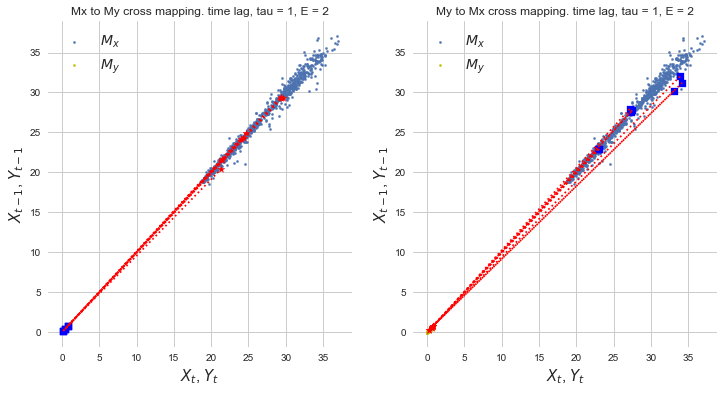

In [73]:
ccm1.visualize_cross_mapping()

In [74]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm1.causality()
corr_, p

(0.4756752590914322, 4.887606002571314e-49)

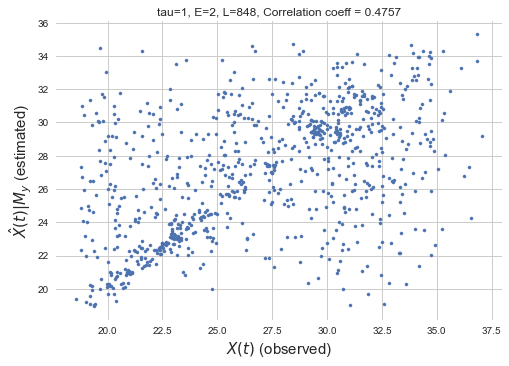

In [75]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm1.plot_ccm_correls()

X->Y r 0.48 p value 0.0
Y->X r 0.18 p value 2.31e-07


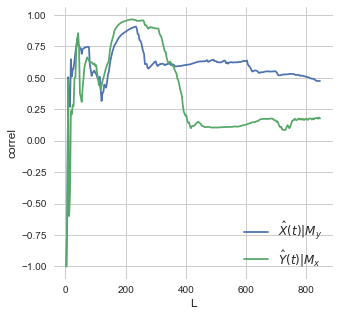

In [76]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X1), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X1, Y1, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y1, X1, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

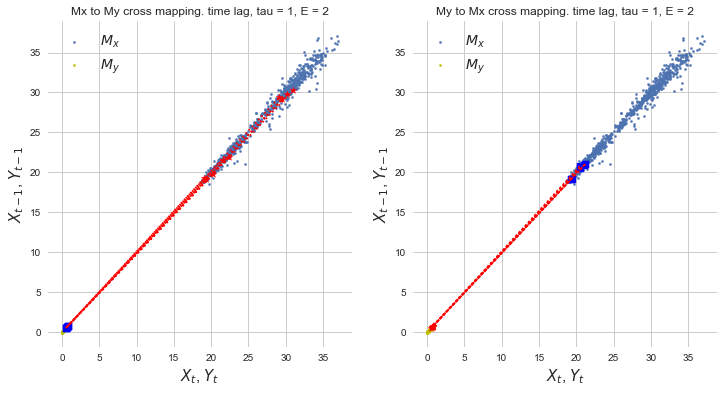

In [77]:
# LAG WITH ONE WEEK (VIX and BTC_SPX)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X3) # length of time period to consider

# if we wish to check if X causes Y
ccm2 = ccm(X3, Y3, tau, E, L)
ccm2.visualize_cross_mapping()

In [78]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm2.causality()
corr_, p

(0.5448921382691972, 1.1350851766362945e-62)

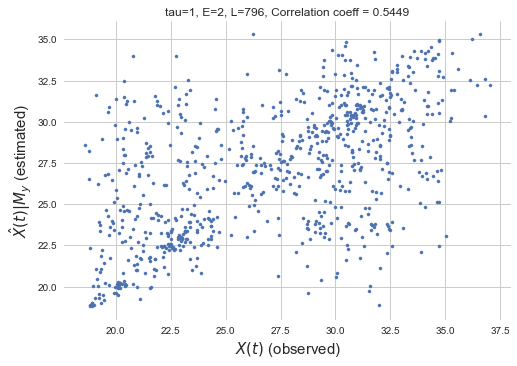

In [79]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm2.plot_ccm_correls()

X->Y r 0.55 p value 0.0
Y->X r 0.39 p value 0.0


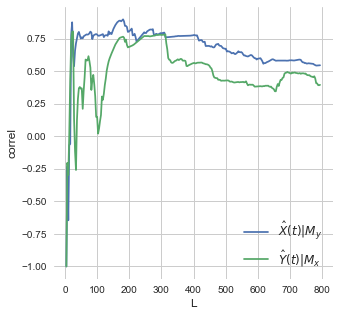

In [80]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X3), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X3, Y3, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y3, X3, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 20))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 20))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

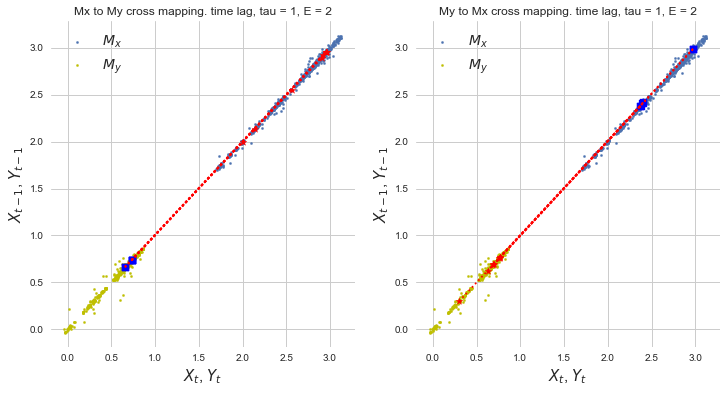

In [81]:
# LAG WITH ONE DAY (BOND and BTC_SPX)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X2) # length of time period to consider

# if we wish to check if X causes Y
ccm3 = ccm(X2, Y1, tau, E, L)
ccm3.visualize_cross_mapping()

In [82]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm3.causality()
corr_, p

(0.4980375702266828, 2.7009142627729007e-54)

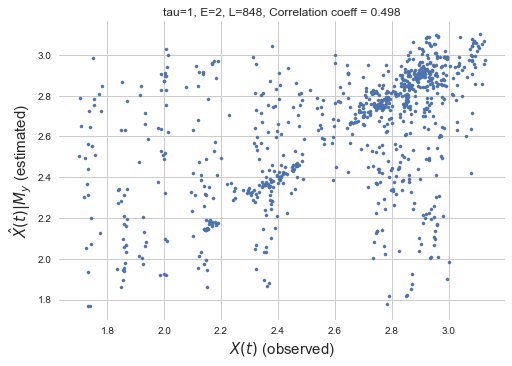

In [83]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm3.plot_ccm_correls()

X->Y r 0.5 p value 0.0
Y->X r 0.42 p value 0.0


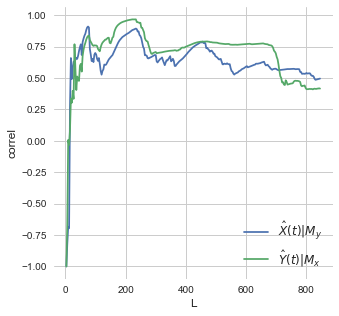

In [84]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X2), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X2, Y1, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y1, X2, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

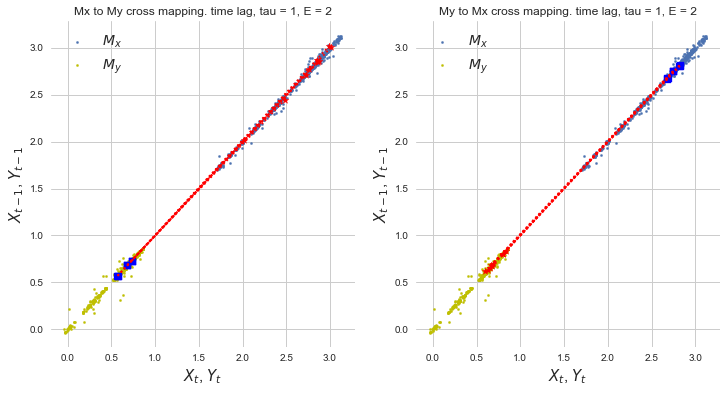

In [85]:
# LAG WITH ONE WEEK (BOND and BTC_SPX)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X4) # length of time period to consider

# if we wish to check if X causes Y
ccm4 = ccm(X4, Y3, tau, E, L)
ccm4.visualize_cross_mapping()

In [86]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm4.causality()
corr_, p

(0.49441644107561616, 3.0782722013223385e-50)

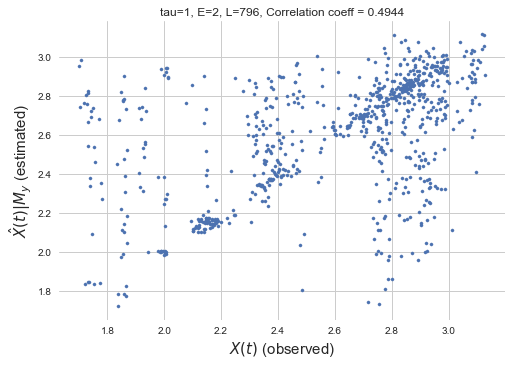

In [87]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm4.plot_ccm_correls()

X->Y r 0.44 p value 0.0
Y->X r 0.19 p value 3.67e-08


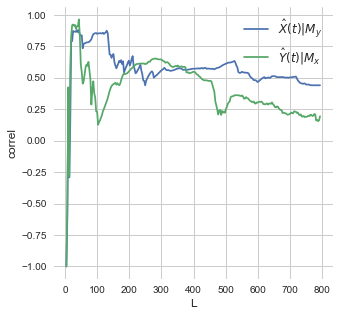

In [88]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X3), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X3, Y4, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y4, X3, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

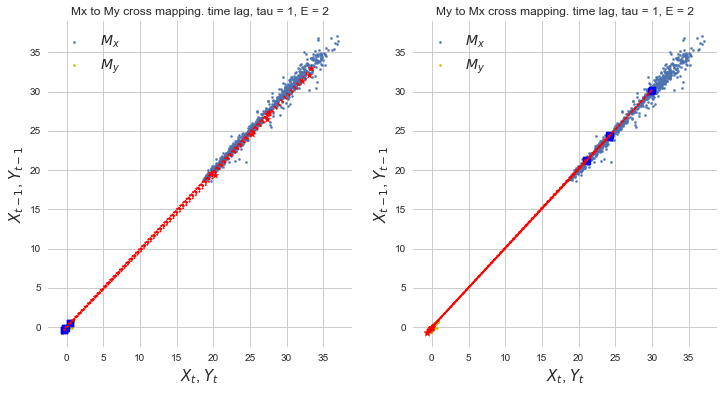

In [89]:
# LAG WITH ONE DAY (VIX and BTC_GOLD)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X1) # length of time period to consider

# if we wish to check if X causes Y
ccm5 = ccm(X1, Y2, tau, E, L)
ccm5.visualize_cross_mapping()

In [90]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm5.causality()
corr_, p

(0.39935409680816786, 9.017970866251667e-34)

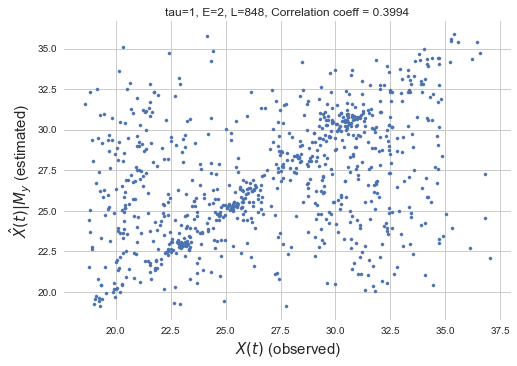

In [91]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm5.plot_ccm_correls()

X->Y r 0.4 p value 0.0
Y->X r 0.31 p value 0.0


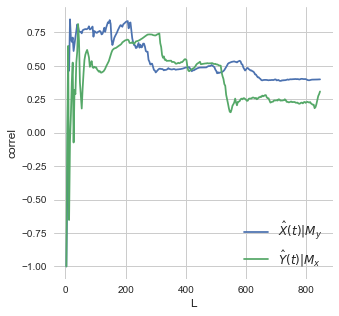

In [92]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X1), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X1, Y2, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y2, X1, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

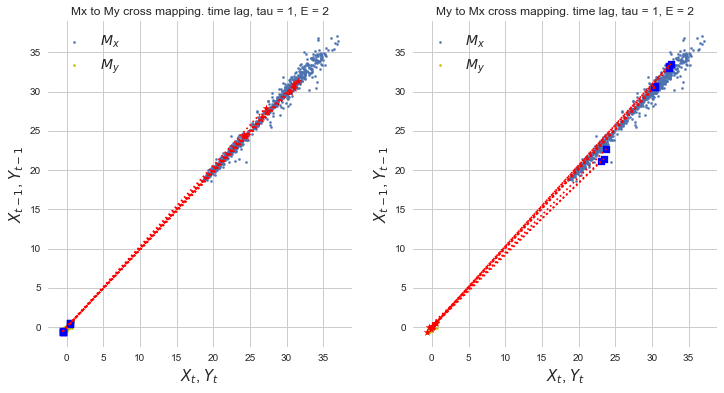

In [93]:
# LAG WITH ONE WEEK (VIX and BTC_GOLD)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X3) # length of time period to consider

# if we wish to check if X causes Y
ccm6 = ccm(X3, Y4, tau, E, L)
ccm6.visualize_cross_mapping()

In [94]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm6.causality()
corr_, p

(0.44015811106233965, 5.295109879601896e-39)

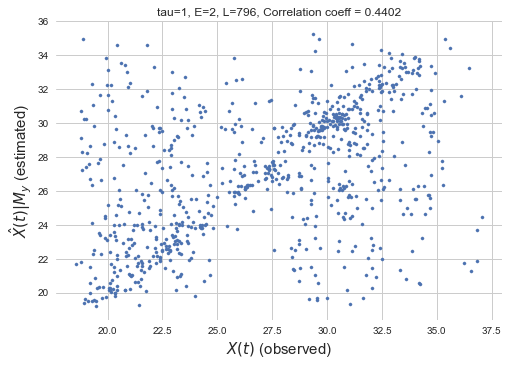

In [95]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm6.plot_ccm_correls()

X->Y r 0.44 p value 0.0
Y->X r 0.19 p value 3.67e-08


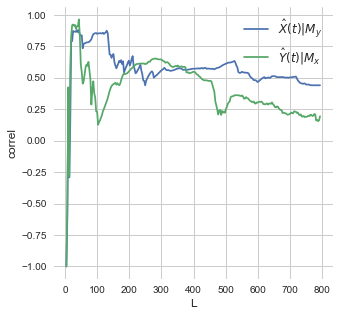

In [96]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X3), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X3, Y4, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y4, X3, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

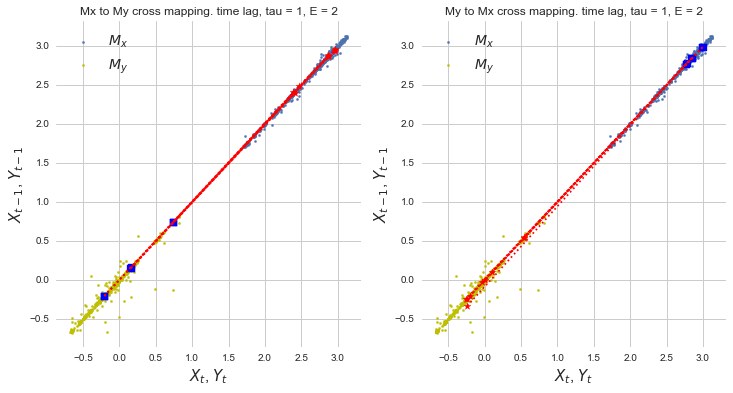

In [97]:
# LAG WITH ONE DAY (BOND and BTC_GOLD)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X2) # length of time period to consider

# if we wish to check if X causes Y
ccm7 = ccm(X2, Y2, tau, E, L)
ccm7.visualize_cross_mapping()

In [98]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm7.causality()
corr_, p

(0.7428915548048063, 1.8963845933249462e-149)

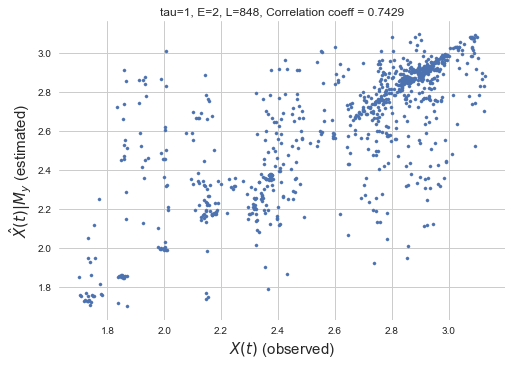

In [99]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm7.plot_ccm_correls()

X->Y r 0.74 p value 0.0
Y->X r 0.7 p value 0.0


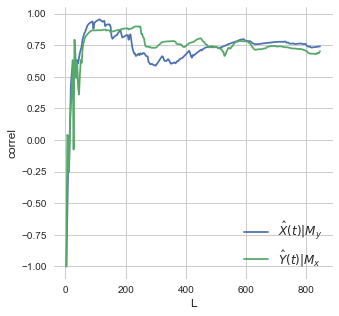

In [100]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X2), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X2, Y2, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y2, X2, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

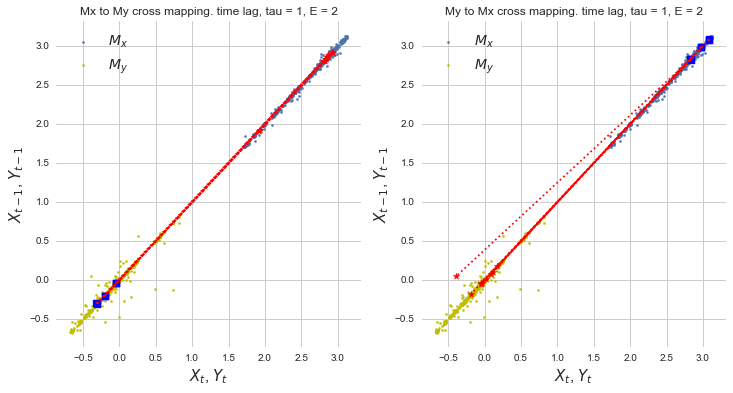

In [101]:
# LAG WITH ONE DAY (BOND and BTC_GOLD)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X4) # length of time period to consider

# if we wish to check if X causes Y
ccm8 = ccm(X4, Y4, tau, E, L)
ccm8.visualize_cross_mapping()

In [102]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
corr_, p = ccm8.causality()
corr_, p

(0.6209143520215877, 6.273236067471578e-86)

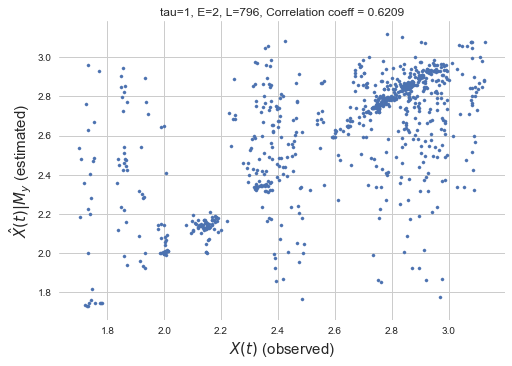

In [103]:
# visualize correlation of X->Y
# stronger correlation = stronger causal relationship
ccm8.plot_ccm_correls()

X->Y r 0.62 p value 0.0
Y->X r 0.52 p value 0.0


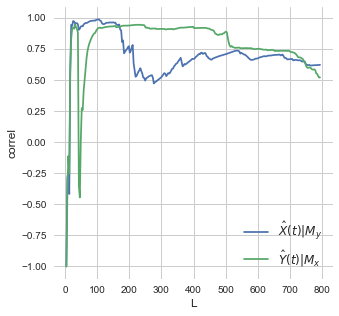

In [104]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X4), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X4, Y4, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y4, X4, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

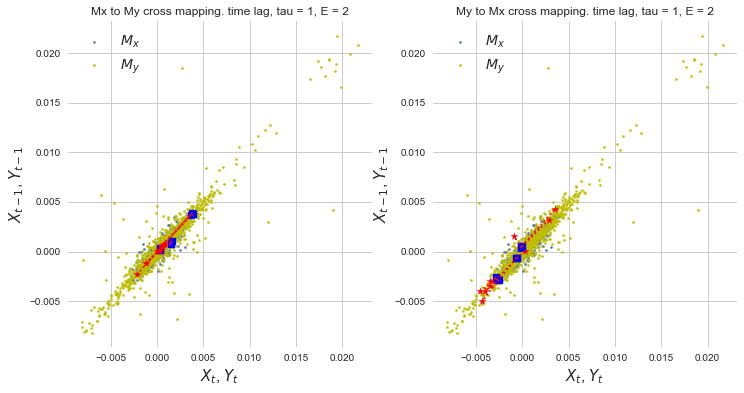

In [113]:
# LAG WITH ONE DAY (BOND and BTC_GOLD)
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X4) # length of time period to consider

# if we wish to check if X causes Y
ccm9 = ccm(X5, Y5, tau, E, L)
ccm9.visualize_cross_mapping()

In [115]:
# checking convergence
# Looking at "convergence"
L_range = range(3, len(X5), 3) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X5, Y5, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y5, X5, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 10))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 10))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})

ValueError: array must not contain infs or NaNs